In [43]:
import os
import sys
import numpy as np
import argparse
import h5py
import math
import random
import time
import logging
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import csv
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import torch
import torchaudio
#torch.backends.cudnn.benchmark=True
#torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
 
sys.path.append("utils")
from utilities import get_filename
sys.path.append("pytorch/")
from models import *
import config

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [44]:
class Transfer_Cnn14(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn14, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn14(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(2048, classes_num, bias=True)

        if freeze_base:
            # Freeze AudioSet pretrained layers
            for param in self.base.parameters():
                param.requires_grad = False

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path)
        self.base.load_state_dict(checkpoint['model'])

    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']

        clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        print("Saída do modelo (shape):", clipwise_output.shape)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

In [45]:
class Transfer_Cnn10(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn10, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn10(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(512, classes_num, bias=True)

        if freeze_base:
            # Freeze AudioSet pretrained layers
            for param in self.base.parameters():
                param.requires_grad = False

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path)
        self.base.load_state_dict(checkpoint['model'])

    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']
        #print(embedding.shape)
        #print(self.fc_transfer(embedding).shape)
        clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

In [46]:
# Dados de treino

data_respiration_target_dictionary = {}

folder = '../../SPIRA/SPIRA_Dataset_V2/com_ruido/'
train_csv = '../../SPIRA/SPIRA_Dataset_V2/metadata_train.csv'
df = pd.read_csv(train_csv)

data_paths_train = []

for row in range(len(df)):
    file = df['file_path'][row]
    label = df['class'][row]
    #file_path = folder+file  
    if(label == 1):
        file = file[:10] + 'pacientes_' + file[10:]
        file_path = folder+file
    else:
        file = file[:9] + 'controle_' + file[9:]
        file_path = folder+file 
    data_path = file_path
    data_paths_train.append(data_path)
    
    data_respiration_target_dictionary[file_path] = label

random.shuffle(data_paths_train)

print(data_paths_train)

['../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_067fb470-5b63-4b1f-b2ca-bb97754bc60d_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_4188922f-98db-43c1-97c2-3c1afca832df_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200615-WA0023.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200513-WA0038.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200614-WA0017.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_0600c923-0ba4-498b-93b1-f6c53521dba3_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200615-WA0017.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_115e681f-ee02-4fa6-a491-a00220e49810_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200612-WA0001.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200516-WA0008.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-2020060

In [47]:
#Dados de Validação
folder = '../../SPIRA/SPIRA_Dataset_V2/com_ruido/'
eval_csv = '../../SPIRA/SPIRA_Dataset_V2/metadata_eval.csv'
df = pd.read_csv(eval_csv)

data_paths_valid = []

for row in range(len(df)):
    file = df['file_path'][row]
    label = df['class'][row]
    #file_path = folder+file  
    if(label == 1):
        file = file[:10] + 'pacientes_' + file[10:]
        file_path = folder+file
    else:
        file = file[:9] + 'controle_' + file[9:]
        file_path = folder+file 
    data_path = file_path
    data_paths_valid.append(data_path)
    
    data_respiration_target_dictionary[file_path] = label

random.shuffle(data_paths_valid)

print(data_paths_valid)

['../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_ba41ef55-f9aa-485d-9577-d80557f16a8a_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_4a7bbfff-84d6-4534-ade2-75ba2ff40508_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_3be2d127-d3a5-4f87-8e69-ac94a4426d5c_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200601-WA0005.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200525-WA0005.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200612-WA0025.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200521-WA0007.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_22e8506a-9916-49b9-ac5d-21b397276e4a_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200530-WA0013.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200513-WA0025.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_9feaa947-c07c

In [48]:
#Dados de Teste

folder = '../../SPIRA/SPIRA_Dataset_V2/'
test_csv = '../../SPIRA/SPIRA_Dataset_V2/metadata_test.csv'
df = pd.read_csv(test_csv)

data_paths_test = []
data_paths_no_label_test = []

for row in range(len(df)):
    file = df['file_path'][row]
    file_path = folder+file  
    data_path = file_path
    data_paths_test.append(data_path)
    label = df['class'][row]
    data_respiration_target_dictionary[file_path] = label
    data_paths_no_label_test.append(data_path)
random.shuffle(data_paths_test)
#folder = '../../SPIRA/SPIRA_Dataset_V2/pacientes/'

#data_paths_test = []

#for file in os.listdir(folder):
#    file_path = folder + file
#    #to be consistent with rest of the code - we do not want to split these into 4 seconds audios
#    data_path = file_path
#    data_paths_test.append(data_path)
#    v = file.replace('.wav','').split('_')
#    emotion_label = v[len(v)-1]
#    data_emotion_target_dictionary[file_path] = emotion_label

print(data_paths_test)

['../../SPIRA/SPIRA_Dataset_V2/pacientes/PTT-20200615-WA0038.wav', '../../SPIRA/SPIRA_Dataset_V2/pacientes/PTT-20200608-WA0019.wav', '../../SPIRA/SPIRA_Dataset_V2/controle/d59c2b26-f334-4019-bf33-a205b5241afd_1.wav', '../../SPIRA/SPIRA_Dataset_V2/pacientes/PTT-20200513-WA0017.wav', '../../SPIRA/SPIRA_Dataset_V2/pacientes/PTT-20200530-WA0007.wav', '../../SPIRA/SPIRA_Dataset_V2/pacientes/PTT-20200616-WA0011.wav', '../../SPIRA/SPIRA_Dataset_V2/pacientes/PTT-20200615-WA0040.wav', '../../SPIRA/SPIRA_Dataset_V2/controle/5116af46-aa3d-48cf-abb4-e1cc379f4ad5_1.wav', '../../SPIRA/SPIRA_Dataset_V2/controle/1e390194-a85a-4eae-bceb-52285c03fb1d_1.wav', '../../SPIRA/SPIRA_Dataset_V2/controle/bd45f49b-e235-4db1-84d8-3a39e6de989e_1.wav', '../../SPIRA/SPIRA_Dataset_V2/controle/5aa450f4-40a2-4c48-9cd5-0eee107f1fe8_1.wav', '../../SPIRA/SPIRA_Dataset_V2/controle/cac84a55-c9d9-4126-b8c7-cd8dd6b21e30_1.wav', '../../SPIRA/SPIRA_Dataset_V2/pacientes/PTT-20200607-WA0006.wav', '../../SPIRA/SPIRA_Dataset_V2/con

In [49]:
folder = '../../SPIRA/SPIRA_Dataset_V2/com_ruido/'
test_csv = '../../SPIRA/SPIRA_Dataset_V2/metadata_test.csv'
df = pd.read_csv(test_csv)

data_paths_no_label_test3 = []

for row in range(len(df)):
    file = df['file_path'][row]
    label = df['class'][row]
    if(label == 1):
        file = file[:10] + 'pacientes_' + file[10:]
        file_path = folder+file
    else:
        file = file[:9] + 'controle_' + file[9:]
        file_path = folder+file  
    data_path = file_path
    data_paths_no_label_test3.append(data_path)
    
    data_respiration_target_dictionary[file_path] = label

random.shuffle(data_paths_no_label_test3)
print(data_paths_no_label_test3)

['../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200601-WA0013.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_ec7d093b-9349-47b1-8fab-944a0b18b6ec_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_4dec013b-ec5b-4526-91c7-a4ea770b7f9a_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200614-WA0025.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_cac84a55-c9d9-4126-b8c7-cd8dd6b21e30_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200613-WA0023.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_a5e563d0-ee38-4d1f-81b6-453d308f751d_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_2df12335-ce59-47d2-acac-ebd5ea720601_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/pacientes/pacientes_PTT-20200601-WA0027.wav', '../../SPIRA/SPIRA_Dataset_V2/com_ruido/controle/controle_a68344d1-34e6-406f-bef5-0370e930344f_1.wav', '../../SPIRA/SPIRA_Dataset_V2/com_rui

In [50]:
#build function to process data in batches
def process_batches(data_paths, data_emotion_target_dictionary, number_coeffs, min_frequency, max_frequency, batch_size, pretrain, path_index):
    
    #parameters below maybe should be defined elsewhere
    #set audio length in seconds - this is max length of audios
    audio_length = 30
    device = 'cuda'
    new_sample_rate = 32000
    
    ################################
    
    data_batch = []
    
    #in case we are doing supervised training we also need to store whether the file comes from healthy/unhealthy - is always computed but only used for supervised training
    data_ri_target_list = []
    data_gen_target_list = []
    data_age_target_list = []
    data_emotion_target_list = []
    
    while len(data_batch) < batch_size and path_index < len(data_paths):
        data_path_with_index = data_paths[path_index]
        data_path = data_path_with_index
        sample_rate = torchaudio.info(data_path).sample_rate
        
        data_elem, sample_rate = torchaudio.load(data_path)
        #downsampling to fit gpu memory
        data_elem = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(data_elem)
        sample_rate = new_sample_rate
        data_elem = data_elem[0]
        
        data_batch.append(data_elem)
        
        #for supervised training we store data about the file
        if pretrain != 'pretrain':
            if pretrain == 'emotion':
                if data_emotion_target_dictionary[data_path] == 'neutral':
                    data_emotion_target_list.append(0)
                elif data_emotion_target_dictionary[data_path] == 'non-neutral-male':
                    data_emotion_target_list.append(1)
                elif data_emotion_target_dictionary[data_path] == 'non-neutral-female':
                    data_emotion_target_list.append(2)
                else:#this should not happen
                    data_emotion_target_list.append(3)
            elif pretrain == 'respiration':
                #print(data_emotion_target_dictionary[data_path])
                if data_emotion_target_dictionary[data_path] == 0:
                    data_emotion_target_list.append(0)
                elif data_emotion_target_dictionary[data_path] == 1:
                    data_emotion_target_list.append(1)
                else:#this should not happen
                    raise ValueError(f"Rótulo inválido para '{data_path}': {data_emotion_target_dictionary[data_path]}")
        
        path_index +=1
        
    #convert list to torch tensor (pads different audio lengths to same size)
    data_batch = nn.utils.rnn.pad_sequence(data_batch, batch_first=True)
    
    data_batch = data_batch.to(device)
    
    #for supervised training
    data_emotion_target_list = torch.LongTensor(data_emotion_target_list)
    data_emotion_target_list = data_emotion_target_list.to(device)
    ###########################
    
    #data_batch = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=number_coeffs, f_min=min_frequency, f_max=max_frequency).to(device)(data_batch)
    #print(data_batch.shape)

    
    #permute so we have batch_size, time, n_coeffs
    #data_batch = data_batch.permute(0,2,1)

    return data_batch, data_emotion_target_list, path_index

In [51]:
#function to train model
def run_epoch(model, loss_compute, data_paths, avg_loss=0, pretrain='pretrain', training=True, batch_size=16, extract_coeffs='both', min_frequency = 0.0, max_frequency=None, number_coeffs=128, mask_proportion=0., mask_consecutive_frames=7, mask_frequency_proportion=0., random_noise_proportion=0.0):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    train_acc_avg = 0
    f1_score_avg = 0
    
    number_elements = len(data_paths)
    #number_steps = int(math.ceil(number_elements/batch_size))
    
    outputs=[]
    targets=[]
    
    #path index is the index of the audio file in the filenames list
    path_index = 0
    #step index stores the amount of steps taken by the algorithm so far
    step_index = 0
    while path_index < number_elements:
        step_index +=1
        #load the data and mask it
        data_batch, data_emotion_target_list, path_index = process_batches(data_paths, data_respiration_target_dictionary, number_coeffs, min_frequency, max_frequency, batch_size, pretrain, path_index)
        b_size = data_batch.shape[0]
        #pass data through transformer
        #print(data_batch.shape)
        output_dict = model.forward(data_batch)
        #compute loss
        #print('out', out.shape)
        #print('data_batch', data_batch.shape)
        if pretrain == 'pretrain':
            loss, train_acc = loss_compute(output_dict, data_batch, training)
        elif pretrain == 'emotion':
            loss, train_acc, f1_score, output, target = loss_compute(output_dict, data_emotion_target_list, training)
        elif pretrain == 'respiration':
            loss, train_acc, f1_score, output, target = loss_compute(output_dict, data_emotion_target_list, training)
        
        outputs.append(output)
        targets.append(target)

        total_loss += loss
        avg_loss = avg_loss*0.99 + loss*0.01
        train_acc_avg = (train_acc_avg*(step_index-1)+train_acc)/(step_index)
        f1_score_avg = (f1_score_avg*(step_index-1)+f1_score)/(step_index)
        total_tokens += b_size
        tokens += b_size
        
        if step_index % 5 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f Train_acc: %f F1_score: %f" %
                    (step_index, avg_loss, tokens / elapsed, train_acc_avg, f1_score_avg))
            start = time.time()
            tokens = 0

    outputs = np.concatenate(outputs)
    targets = np.concatenate(targets)
    true_f1_score = sklearn.metrics.f1_score(targets, outputs, labels=[0,1], average='macro')
    print('Final F1_score=', true_f1_score)
    
    return total_loss / (total_tokens), avg_loss, train_acc_avg, f1_score_avg, true_f1_score

In [52]:
#function to write model test outputs to a csv file
def write_to_csv(model, csv_filepath, data_paths):
    header = ['file_path', 'label']
    with open(csv_filepath, 'w') as f:
        writer = csv.writer(f)
        #write header
        writer.writerow(header)

        new_sample_rate = 32000
        
        for index in range(len(data_paths)):
            data_batch = []
            data_path = data_paths[index]
            data_elem, sample_rate = torchaudio.load(data_path)
            #downsampling to fit gpu memory
            data_elem = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(data_elem)
            sample_rate = new_sample_rate
            data_elem = data_elem[0]
            data_batch.append(data_elem)
            #convert to tensor with batch size 1
            data_batch = nn.utils.rnn.pad_sequence(data_batch, batch_first=True)
            data_batch = data_batch.to(device)
            #run model
            output_dict = model.forward(data_batch)
            _, predicted = torch.max(output_dict['clipwise_output'], 1)
            preds = predicted.detach().cpu().clone()
            #print(output_dict['clipwise_output'])
            if preds[0] == 0:
                pred_string = '0'
            elif preds[0] == 1:
                pred_string = '1'
            #elif preds[0] == 2:
            #    pred_string = 'non-neutral-female'
            #we use data_path[26:] to remove the folder from the path
            data_row = [data_path[29:], pred_string]
            print(data_row)
            writer.writerow(data_row)
            
    return True
            

In [53]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        #return self.factor * \ (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        return 0.0001
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
class LossCompute:
    "A simple loss compute and train function."
    def __init__(self, model, opt=None, pretrain='pretrain'):
        self.model = model
        self.opt = opt
        self.pretrain = pretrain
        
    def __call__(self, output_dict, y, training):
        train_acc = 0
        f1_score=0
        if self.pretrain == 'pretrain':
            L1_loss = nn.L1Loss()
            loss = L1_loss(output_dict['clipwise_output'], y)
        else: #emotion/respiration?

            cross_entropy_loss = nn.CrossEntropyLoss()
            loss = cross_entropy_loss(output_dict['clipwise_output'], y)
            _, predicted = torch.max(output_dict['clipwise_output'], 1)
            train_acc = torch.sum(predicted==y)/y.shape[0]
            preds = predicted.detach().cpu().clone()
            y_true = y.detach().cpu().clone()
            f1_score = sklearn.metrics.f1_score(y_true, preds, labels=[0,1], average='macro')
            
        if training == True:
            loss.backward()
            if self.opt is not None:
                self.opt.step()
                self.opt.optimizer.zero_grad()
        return loss.data.item(), train_acc, f1_score, preds, y_true

In [55]:
args = {}
args['sample_rate']= 32000
args['window_size']= 1024
args['hop_size']=320
args['mel_bins']=64
args['fmin']=0
args['fmax']=32000
args['model_type']="Transfer_Cnn10"
args['pretrained_checkpoint_path']="Cnn10_mAP=0.380.pth"
args['freeze_base']=False
args['cuda']=True

In [56]:

# Arguments & parameters
sample_rate = args['sample_rate']
window_size = args['window_size']
hop_size = args['hop_size']
mel_bins = args['mel_bins']
fmin = args['fmin']
fmax = args['fmax']
model_type = args['model_type']
pretrained_checkpoint_path = args['pretrained_checkpoint_path']
freeze_base = args['freeze_base']
device = 'cuda' if (args['cuda'] and torch.cuda.is_available()) else 'cpu'
classes_num = 2#config.classes_num
pretrain = True if pretrained_checkpoint_path else False

# Model
Model = eval(model_type)
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num, freeze_base)


# Load pretrained model
if pretrain:
    logging.info('Load pretrained model from {}'.format(pretrained_checkpoint_path))
    model.load_from_pretrain(pretrained_checkpoint_path)


if 'cuda' in device:
    model.to(device)

print('Load pretrained model successfully!')


Load pretrained model successfully!


/home/luan/.local/lib/python3.10/site-packages/torchlibrosa/stft.py:686: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,


In [ ]:
#pretrain = 'emotion'
pretrain = 'respiration'
d_model = 512
model_opt = NoamOpt(d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

avg_loss=0
best_val_acc = 0
best_val_f1_score = 0
model_path = 'model_test_mel.ckpt'
min_frequency = 0.0
max_frequency = None

train_accs = []
train_f1s = []
val_accs = []
val_f1s = []

for epoch in range(100):
    model.train()
    loss, avg_loss, train_acc, train_f1, _ = run_epoch(model, 
                  LossCompute(model, model_opt, pretrain),
                  data_paths_train, pretrain=pretrain, training=True, avg_loss=avg_loss,
                  min_frequency=min_frequency, max_frequency=max_frequency, number_coeffs=64)
    
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    model.eval()
    with torch.no_grad():
        loss, _, val_acc, val_f1_score, true_val_f1_score = run_epoch(model, 
                    LossCompute(model, None, pretrain=pretrain),
                    data_paths_valid, pretrain=pretrain, training=False,
                    min_frequency=min_frequency, max_frequency=max_frequency, number_coeffs=64)
        
        val_accs.append(val_acc)
        val_f1s.append(val_f1_score)
        print(val_acc)
        print(val_f1_score)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        print('Saving model')
        torch.save({
            'model_state_dict': model.state_dict()
            }, model_path)
    # if best_val_f1_score < true_val_f1_score:
    #     best_val_f1_score = true_val_f1_score
    #     print('Saving model')
    #     torch.save({
    #         'model_state_dict': model.state_dict()
    #         }, model_path)
        #torch.save(model, model_path)


Epoch Step: 1 Loss: 0.010162 Tokens per Sec: 28.474086 Train_acc: 0.500000 F1_score: 0.466667
Epoch Step: 6 Loss: 0.049455 Tokens per Sec: 29.491101 Train_acc: 0.500000 F1_score: 0.479365
Epoch Step: 11 Loss: 0.088894 Tokens per Sec: 26.424239 Train_acc: 0.465909 F1_score: 0.450922
Epoch Step: 16 Loss: 0.124608 Tokens per Sec: 26.723395 Train_acc: 0.468750 F1_score: 0.451712
Final F1_score= 0.4631270536042608
Epoch Step: 1 Loss: 0.006107 Tokens per Sec: 44.503109 Train_acc: 0.812500 F1_score: 0.805668
Final F1_score= 0.718475073313783
tensor(0.7188, device='cuda:0')
0.7123578176209755
Saving model
Epoch Step: 1 Loss: 0.149074 Tokens per Sec: 28.709208 Train_acc: 0.687500 F1_score: 0.686275
Epoch Step: 6 Loss: 0.178375 Tokens per Sec: 29.549307 Train_acc: 0.614583 F1_score: 0.600927
Epoch Step: 11 Loss: 0.197910 Tokens per Sec: 26.566832 Train_acc: 0.636364 F1_score: 0.617707
Epoch Step: 16 Loss: 0.218813 Tokens per Sec: 26.881927 Train_acc: 0.621094 F1_score: 0.595624
Final F1_score= 0

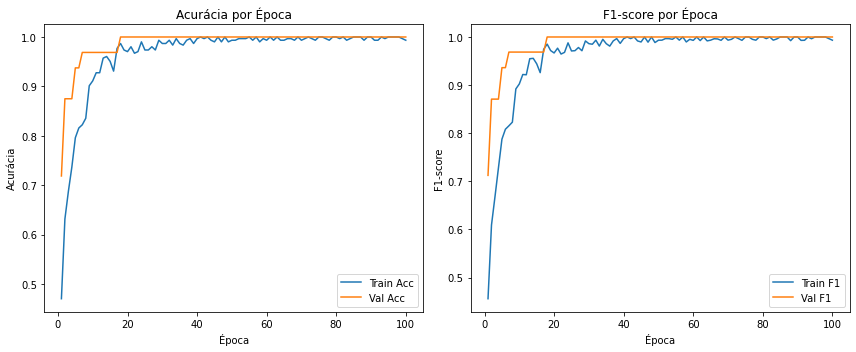

In [58]:
epochs = list(range(1, len(train_accs) + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, [x.cpu().item() if torch.is_tensor(x) else x for x in train_accs], label='Train Acc')
plt.plot(epochs, [x.cpu().item() if torch.is_tensor(x) else x for x in val_accs], label='Val Acc')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1s, label='Train F1')
plt.plot(epochs, val_f1s, label='Val F1')
plt.title('F1-score por Época')
plt.xlabel('Época')
plt.ylabel('F1-score')
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
model_path = 'model_test_mel.ckpt'
Model = eval(model_type)
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num, freeze_base)

# Load trained model
logging.info('Load pretrained model from {}'.format(model_path))
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

if 'cuda' in device:
    model.to(device)
V=64
pretrain = 'respiration'
model.eval()
with torch.no_grad():
    print(run_epoch(model,
                        LossCompute(model, None, pretrain=pretrain),
                        data_paths_valid, pretrain=pretrain, training=False, number_coeffs=64))
    print(run_epoch(model, 
                        LossCompute(model, None, pretrain=pretrain),
                        data_paths_test, pretrain=pretrain, training=False, number_coeffs=64))
    csv_filepath = 'test.csv'
    print(write_to_csv(model, csv_filepath, data_paths_no_label_test))

/home/luan/.local/lib/python3.10/site-packages/torchlibrosa/stft.py:686: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,


Epoch Step: 1 Loss: 0.000091 Tokens per Sec: 42.154074 Train_acc: 1.000000 F1_score: 1.000000
Final F1_score= 1.0
(0.0014181016013026237, 0.00045288418754935264, tensor(1., device='cuda:0'), 1.0, 1.0)
Epoch Step: 1 Loss: 0.000987 Tokens per Sec: 30.223201 Train_acc: 0.937500 F1_score: 0.937255
Epoch Step: 6 Loss: 0.004246 Tokens per Sec: 28.624532 Train_acc: 0.958333 F1_score: 0.954659
Final F1_score= 0.9629120879120879
(0.004355683853780782, 0.004539263715729796, tensor(0.9643, device='cuda:0'), 0.9611358640953087, 0.9629120879120879)
['pacientes/PTT-20200511-WA0007.wav', '1']
['pacientes/PTT-20200511-WA0014.wav', '1']
['pacientes/PTT-20200513-WA0007.wav', '1']
['pacientes/PTT-20200513-WA0017.wav', '1']
['pacientes/PTT-20200516-WA0010.wav', '1']
['pacientes/PTT-20200518-WA0005.wav', '1']
['pacientes/PTT-20200518-WA0009.wav', '1']
['pacientes/PTT-20200519-WA0007.wav', '1']
['pacientes/PTT-20200522-WA0007.wav', '1']
['pacientes/PTT-20200529-WA0011.wav', '1']
['pacientes/PTT-20200530-WA0

[[54  0]
 [ 4 50]]
Acurácia: 0.9630
0.9629629629629629
0.9615384615384616


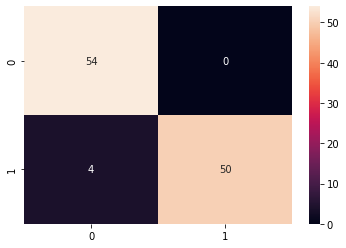

In [60]:
#confusion matrix
import pandas

csv_filepath = 'test.csv'
prediction_labels = pandas.read_csv(csv_filepath)
test_folder = '../../SPIRA/SPIRA_Dataset_V2/'


prediction_labels_list = []
true_labels_list = []

for index in range(len(prediction_labels['file_path'])):
    file = prediction_labels['file_path'][index]
    prediction_label = prediction_labels['label'][index]
    prediction_labels_list.append(prediction_label)

    #need to check which file_path is in data_emotion_target_dictionary
    file_path = os.path.join(test_folder, file)
    # if file_path in data_respiration_target_dictionary:
    #     true_label = data_respiration_target_dictionary[file_path]
    # file_path = test_folder+file[:-4]+'_non-neutral-female.wav'
    # if file_path in data_respiration_target_dictionary:
    #     true_label = data_respiration_target_dictionary[file_path]
    # file_path = test_folder+file[:-4]+'_non-neutral-male.wav'
    # if file_path in data_respiration_target_dictionary:
    true_label = data_respiration_target_dictionary[file_path]

    if true_label is None:
        print(f"Aviso: arquivo {file_path} não encontrado no dicionário!")
        continue
    
    true_labels_list.append(true_label)
        
prediction_labels_list = np.array(prediction_labels_list)        
true_labels_list = np.array(true_labels_list)        
#labels = ['neutral', 'non-neutral-male', 'non-neutral-female']
#labels = ['0','1']
confusion_matrix = sklearn.metrics.confusion_matrix(true_labels_list, prediction_labels_list, labels=[0, 1])
print(confusion_matrix)

f = sns.heatmap(confusion_matrix, annot=True, fmt='d')

acc_sem_ruido = accuracy_score(true_labels_list, prediction_labels_list)
f1_sem_ruido = f1_score(true_labels_list, prediction_labels_list)
print(f"Acurácia: {accuracy_score(true_labels_list, prediction_labels_list):.4f}")
print(acc_sem_ruido)
print(f1_sem_ruido)



In [61]:
model_path = 'model_test_mel.ckpt'
Model = eval(model_type)
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num, freeze_base)

# Load trained model
logging.info('Load pretrained model from {}'.format(model_path))
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

if 'cuda' in device:
    model.to(device)
V=64
pretrain = 'respiration'
model.eval()
with torch.no_grad():
    print(run_epoch(model,
                        LossCompute(model, None, pretrain=pretrain),
                        data_paths_no_label_test3, pretrain=pretrain, training=False, number_coeffs=64))
    print(run_epoch(model, 
                        LossCompute(model, None, pretrain=pretrain),
                        data_paths_no_label_test3, pretrain=pretrain, training=False, number_coeffs=64))
    
    csv_filepath = 'test_noise.csv'
    print(write_to_csv(model, csv_filepath, data_paths_no_label_test3))


/home/luan/.local/lib/python3.10/site-packages/torchlibrosa/stft.py:686: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,


Epoch Step: 1 Loss: 0.001003 Tokens per Sec: 49.355350 Train_acc: 0.937500 F1_score: 0.935223
Epoch Step: 6 Loss: 0.008249 Tokens per Sec: 49.399412 Train_acc: 0.947917 F1_score: 0.939834
Final F1_score= 0.9349117520447697
(0.011408908508235106, 0.012030472569485839, tensor(0.9315, device='cuda:0'), 0.9216430499325237, 0.9349117520447697)
Epoch Step: 1 Loss: 0.001003 Tokens per Sec: 49.907905 Train_acc: 0.937500 F1_score: 0.935223
Epoch Step: 6 Loss: 0.008249 Tokens per Sec: 49.605400 Train_acc: 0.947917 F1_score: 0.939834
Final F1_score= 0.9349117520447697
(0.011408908508235106, 0.012030472569485839, tensor(0.9315, device='cuda:0'), 0.9216430499325237, 0.9349117520447697)
['com_ruido/pacientes/pacientes_PTT-20200601-WA0013.wav', '1']
['com_ruido/controle/controle_ec7d093b-9349-47b1-8fab-944a0b18b6ec_1.wav', '0']
['com_ruido/controle/controle_4dec013b-ec5b-4526-91c7-a4ea770b7f9a_1.wav', '0']
['com_ruido/pacientes/pacientes_PTT-20200614-WA0025.wav', '1']
['com_ruido/controle/controle_ca

🔹 Matriz de Confusão:
[[47  7]
 [ 0 54]]


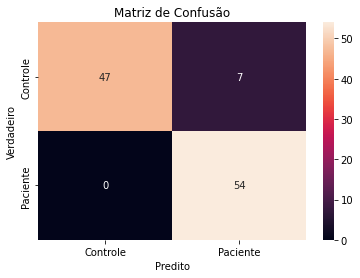


Relatório de Classificação:
              precision    recall  f1-score   support

    Controle       1.00      0.87      0.93        54
    Paciente       0.89      1.00      0.94        54

    accuracy                           0.94       108
   macro avg       0.94      0.94      0.93       108
weighted avg       0.94      0.94      0.93       108

Acurácia: 0.9352
F1-Score: 0.9391


In [62]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Carregando predições
csv_filepath = 'test_noise.csv'
prediction_labels = pd.read_csv(csv_filepath)
test_folder = '../../SPIRA/SPIRA_Dataset_V2/'

prediction_labels_list = []
true_labels_list = []

for index in range(len(prediction_labels['file_path'])):
    file = prediction_labels['file_path'][index]
    prediction_label = prediction_labels['label'][index]
    prediction_labels_list.append(prediction_label)

    file_path = os.path.join(test_folder, file)
    true_label = data_respiration_target_dictionary.get(file_path)

    if true_label is None:
        print(f"Aviso: arquivo {file_path} não encontrado no dicionário!")
        continue

    true_labels_list.append(true_label)

# Convertendo para numpy arrays
prediction_labels_list = np.array(prediction_labels_list)
true_labels_list = np.array(true_labels_list)

# Matriz de confusão
cm = confusion_matrix(true_labels_list, prediction_labels_list, labels=[0, 1])
print("🔹 Matriz de Confusão:")
print(cm)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Controle', 'Paciente'], yticklabels=['Controle', 'Paciente'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# Outras métricas
print("\nRelatório de Classificação:")
print(classification_report(true_labels_list, prediction_labels_list, target_names=['Controle', 'Paciente']))

print(f"Acurácia: {accuracy_score(true_labels_list, prediction_labels_list):.4f}")
print(f"F1-Score: {f1_score(true_labels_list, prediction_labels_list):.4f}")

acc_com_ruido = accuracy_score(true_labels_list, prediction_labels_list)
f1_com_ruido = f1_score(true_labels_list, prediction_labels_list)

In [63]:
with open("Results.txt", "a") as f:
  f.write(f"{acc_sem_ruido} {acc_com_ruido} {f1_sem_ruido} {f1_com_ruido}\n")